# How to use this

Run each cell from top to bottom. 
View README.md for more infos. 

In [ ]:
# Init global infos
%load_ext tensorboard
%tensorflow_version 2.x

import numpy as np
from tensorflow import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import tensorflow as tf
from google.colab import files
import io
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


inputs = (
    ("age", ("continuous",)), 
    ("workclass", ("Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked")), 
    ("fnlwgt", ("continuous",)), 
    ("education", ("Bachelors", "Some-college", "11th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters", "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool")), 
    ("education-num", ("continuous",)), 
    ("marital-status", ("Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse")), 
    ("occupation", ("Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces")), 
    ("relationship", ("Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried")), 
    ("race", ("White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black")), 
    ("sex", ("Female", "Male")),
    ("capital-gain", ("continuous",)), 
    ("capital-loss", ("continuous",)), 
    ("hours-per-week", ("continuous",)), 
    ("native-country", ("United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"))
)

input_shape = []
for i in inputs:
    count = len(i[1 ])
    input_shape.append(count)
input_dim = sum(input_shape)
print("input_shape:", input_shape)
print("input_dim:", input_dim)
print()


outputs = (0, 1)  # (">50K", "<=50K")
output_dim = 2  # len(outputs)
print("output_dim:", output_dim)
print()


input_shape: [1, 8, 1, 16, 1, 7, 14, 6, 5, 2, 1, 1, 1, 41]
input_dim: 105

output_dim: 2



Using TensorFlow backend.


In [ ]:
# Functions to load and prepare data

def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def find_means_for_continuous_types(X):
    means = []
    for col in range(len(X[0])):
        summ = 0
        count = 0.000000000000000000001
        for value in X[:, col]:
            if isFloat(value): 
                summ += float(value)
                count +=1
        means.append(summ/count)
    return means

def prepare_data(raw_data, means):
    
    X = raw_data[:, :-1]
    y = raw_data[:, -1:]
    
    # X:
    def flatten_persons_inputs_for_model(person_inputs):
        global inputs
        global input_shape
        global means
        float_inputs = []

        for i in range(len(input_shape)):
            features_of_this_type = input_shape[i]
            is_feature_continuous = features_of_this_type == 1

            if is_feature_continuous:
                mean = means[i]
                if isFloat(person_inputs[i]):
                    if mean != 0:
                        scale_factor = 1/(2*mean)  # we prefer inputs mainly scaled from -1 to 1.
                    else:
                        scale_factor = 1
                    float_inputs.append(float(person_inputs[i])*scale_factor)
                else:
                    float_inputs.append(mean)
            else:
                for j in range(features_of_this_type):
                    feature_name = inputs[i][1][j]
                    
                    if feature_name == person_inputs[i]:
                        float_inputs.append(1.)
                    else:
                        float_inputs.append(0)
        return float_inputs
    
    new_X = []
    for person in range(len(X)):
        formatted_X = flatten_persons_inputs_for_model(X[person])
        new_X.append(formatted_X)
    new_X = np.array(new_X)
    
    # y:
    new_y = []
    for i in range(len(y)):
        if y[i] == ">50k":
            new_y.append((1, 0))
        else:  # y[i] == "<=50k":
            new_y.append((0, 1))
    new_y = np.array(new_y)
    
    return (new_X, new_y)

In [ ]:
# Building training and test data
uploaded = files.upload()
##training_data = np.genfromtxt(io.BytesIO(uploaded['adult.data.txt']), delimiter=', ', dtype=str, autostrip=True)

Saving adult.data.txt to adult.data.txt


In [ ]:
uploaded = files.upload()
##test_data = np.genfromtxt(io.BytesIO(uploaded['adult.test.txt']), delimiter=', ', dtype=str, autostrip=True)

Saving adult.test.txt to adult.test.txt


In [ ]:
training_data = np.genfromtxt('adult.data.txt', delimiter=', ', dtype=str, autostrip=True)
print("Training data count:", len(training_data))
test_data = np.genfromtxt('adult.test.txt', delimiter=', ', dtype=str, autostrip=True)
print("Test data count:", len(test_data))

Training data count: 32561
Test data count: 16281


In [ ]:
means = find_means_for_continuous_types(np.concatenate((training_data, test_data), 0))
print("Mean values for data types (if continuous):", means)
X_train_general, y_train_general = prepare_data(training_data, means)
X_test_general, y_test_general = prepare_data(test_data, means)

df_data_train = pd.DataFrame(X_train_general).copy()
X_train_male = df_data_train[df_data_train[59] == 0].drop(columns=[59,60]).to_numpy()
X_train_female = df_data_train[df_data_train[59] == 1].drop(columns=[59,60]).to_numpy()

df_data_test = pd.DataFrame(X_test_general).copy()
X_test_male = df_data_test[df_data_test[59] == 0].drop(columns=[59,60]).to_numpy()
X_test_female = df_data_test[df_data_test[59] == 1].drop(columns=[59,60]).to_numpy()

y_train_df = pd.DataFrame(y_train_general).copy()
y_train_male = y_train_df[df_data_train[59] == 0].to_numpy()
y_train_female = y_train_df[df_data_train[59] == 1].to_numpy()

y_test_df = pd.DataFrame(y_test_general).copy()
y_test_male = y_test_df[df_data_test[59] == 0].to_numpy()
y_test_female = y_test_df[df_data_test[59] == 1].to_numpy()

Mean values for data types (if continuous): [38.64358543876172, 0.0, 189664.13459727284, 0.0, 10.078088530363212, 0.0, 0.0, 0.0, 0.0, 0.0, 1079.0676262233324, 87.50231358257237, 40.422382375824085, 0.0, 0.0]


In [ ]:
split_size = 0.1

# Creation of Train and validation dataset
X_train_male, X_val_male, y_train_male, y_val_male = train_test_split(X_train_male,y_train_male,test_size=0.2)
X_train_female, X_val_female, y_train_female, y_val_female = train_test_split(X_train_female,y_train_female,test_size=0.2)

In [ ]:
y_train_woman_zeros = np.zeros((y_train_female.shape[0],1))
y_train_woman_ = np.hstack((y_train_female, y_train_woman_zeros))
y_train_man_ones = np.ones((y_train_male.shape[0],1))
y_train_man_ = np.hstack((y_train_male, y_train_man_ones))

In [ ]:
batch_size = 512
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.BinaryCrossentropy(from_logits=True)
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

# Prepare the training datasets

train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([X_train_female, X_train_male], axis=0), np.concatenate([y_train_woman_,y_train_man_],axis=0)))
train_dataset = train_dataset.shuffle(buffer_size=200000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate((X_val_male,X_val_female)), np.concatenate((y_val_male,y_val_female))))
val_dataset = val_dataset.shuffle(buffer_size=batch_size).batch(batch_size)

In [ ]:
## first model (training of whole model)
input1 = keras.layers.Input(shape=103)
dense1 = keras.layers.Dense(128, activation='relu')(input1)
dense3 = keras.layers.Dense(20, activation='relu')(dense1)
output = keras.layers.Dense(2, activation='softmax')(dense3)

model = keras.Model(inputs=input1, outputs=[dense3,output])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 103)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               13312     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 15,934
Trainable params: 15,934
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def distance_loss(predictions, y, predictions_target, y_target, classes_y):
    def some_function(tensor):
      y_source = tensor[1]
      equal =  tf.math.equal(y_source, y_target)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_target, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    y_equal_source =  tf.math.equal(classes_y, tf.constant(1, dtype=tf.float32))
    y_equal_all_source = tf.reduce_all(y_equal_source, axis=1)
    predictions_source = tf.boolean_mask(predictions, y_equal_all_source)
    y_source = tf.boolean_mask(y, y_equal_all_source)
    d = tf.map_fn(some_function, (predictions_source,y_source), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_target, y_train_target, classes_y):

    with tf.GradientTape() as tape:   
      hidden_logits = model(x_batch, training=True)[0]
      hidden_logits_target = model(x_train_target, training=True)[0]
      loss_ec = distance_loss(hidden_logits, y_batch, hidden_logits_target, y_train_target, classes_y)
      logits = model(x_batch, training=True)[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.05*loss_ec

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_ec, loss_cross
    return loss_value, loss_ec, loss_cross

In [ ]:
dist_losses = []
val_accuracy = []
cross_entropy_losses = []
train_accuracy = []

for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch, y_batch) in train_dataset:
      
      classes_y = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,-1], [y_batch.shape[0],y_batch.shape[0]], [1,1]),dtype=tf.float32)
      y_batch_ = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,0], [y_batch.shape[0],-1], [1,1]),dtype=tf.float32)

      loss_value, loss_dist, loss_cross = train_step(model, optimizer, x_batch, y_batch_, tf.constant(X_train_female, dtype=tf.float32), tf.constant(y_train_female, dtype=tf.float32), classes_y)

     
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Log every 50 batches.
    if step % 50 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Dist loss and cross entropy loss at step %s: %s  %s' % (step, float(loss_dist),float(loss_cross)))

    step +=1
    dist_losses.append(float(loss_dist))
    cross_entropy_losses.append(float(loss_cross))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset: 
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))
    val_accuracy.append(float(val_acc))
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Training acc over epoch: 0.8294302821159363
Training loss (for one batch) at step 0: 0.6456239223480225
Dist loss and cross entropy loss at step 0: 0.5765934586524963  0.616794228553772
Validation acc: 0.8245048522949219
Start of epoch 1
Training acc over epoch: 0.8201397657394409
Training loss (for one batch) at step 0: 0.6498023271560669
Dist loss and cross entropy loss at step 0: 0.7904056906700134  0.6102820634841919
Validation acc: 0.8014739751815796


In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
plt.show()

In [ ]:
plt.plot(dist_losses)
plt.ylabel('euclid_loss')
plt.xlabel('epoch')
plt.show()

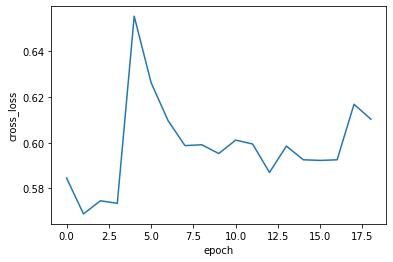

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('cross_loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# retrain last layer of the fair model to predict the gender attribute
y_test_woman_zeros = tf.keras.utils.to_categorical(np.zeros((y_test_female.shape[0],1)), num_classes = 2)
y_test_man_ones = tf.keras.utils.to_categorical(np.ones((y_test_male.shape[0],1)), num_classes = 2)

y_train_gender = tf.keras.utils.to_categorical(np.concatenate((y_train_man_ones, y_train_woman_zeros)), num_classes = 2)

model_1 = keras.models.clone_model(model)
model_1.set_weights(model.get_weights()) 

model_1._layers.pop()
for layer in model_1.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_1.layers[-1].output
output = keras.layers.Dense(2, activation="softmax", name="output")(last)
model_1 = keras.models.Model(model_1.input, output)

for layer in model_1.layers:
    print(layer, layer.trainable)
    
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_1.summary()

history = model_1.fit(np.concatenate((X_train_male,X_train_female)), y_train_gender,epochs=5,
    shuffle=True,
    verbose=1)
score_male = model_1.evaluate(X_test_male, y_test_man_ones, verbose=0)
print('Test loss male:', score_male[0])
print('Test accuracy male:', score_male[1])
score_female = model_1.evaluate(X_test_female, y_test_woman_zeros, verbose=0)
print('Test loss female:', score_female[0])
print('Test accuracy female:', score_female[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0af0069eb8> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0af00610b8> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0b09d332b0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0af00744a8> True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 103)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               13312     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
_________________________________________________________________
output (Dense)               (None, 2)                 42        
Total params: 15,934
Trainable params: 42
Non-trainable params: 15,892
_________

In [ ]:
# retrain the last layer of the fair model to predict the income and calculate
# confusion matrix and fairness measures
model_ = keras.models.clone_model(model)
model_.set_weights(model.get_weights()) 

model_._layers.pop()
for layer in model_.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_.layers[-1].output
output = keras.layers.Dense(2, activation="softmax", name="output")(last)
model_ = keras.models.Model(model_.input, output)

for layer in model_.layers:
    print(layer, layer.trainable)
    
model_.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_.summary()

history = model_.fit(np.concatenate((X_train_male,X_train_female)), np.concatenate((y_train_male, y_train_female)),epochs=5,
    shuffle=True,
    verbose=1)


y_pred_female = model_.predict(X_test_female)
y_pred_female = np.argmax(y_pred_female, axis=1)

y_pred_male = model_.predict(X_test_male)
y_pred_male = np.argmax(y_pred_male, axis=1)

y_test_female_binary = np.argmax(y_test_female, axis=1)
y_test_male_binary = np.argmax(y_test_male, axis=1)

from sklearn.metrics import confusion_matrix
tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female_binary, y_pred_female).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male_binary, y_pred_male).ravel()

## female
prob_true_beutel_female = (tp_female + fp_female)/y_test_female.shape[0]
print("prob_1 female (beutel):", prob_true_beutel_female)
acc_female = (tp_female + tn_female)/y_test_female.shape[0]
print("acc female:", acc_female)
tpr_female = tp_female/(tp_female + fn_female)
print("tpr female:",tpr_female)
ppv_female = tp_female/(tp_female + fp_female)
print("ppv female:",ppv_female)
tnr_female = tn_female/(tn_female + fp_female)
print("tnr female:",tnr_female)

print("---------------------------------------------------")
## male
prob_true_beutel_male = (tp_male + fp_male)/y_test_male.shape[0]
print("prob_1 male (beutel):", prob_true_beutel_male)
acc_male = (tp_male + tn_male)/y_test_male.shape[0]
print("acc male:", acc_male)
tpr_male = tp_male/(tp_male + fn_male)
print("tpr male:", tpr_male)
ppv_male = tp_male/(tp_male + fp_male)
print("ppv male:",ppv_male)
tnr_male = tn_male/(tn_male + fp_male)
print("tnr male:",tnr_male)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel_female - prob_true_beutel_male)
pred_parity = abs(ppv_female - ppv_male)
equal_opportunity = abs(tpr_female - tpr_male) ## = equality_gap_1
equality_gap_0_beutel = abs(tnr_female - tnr_male)
accuracy_gap = abs(acc_female - acc_male)

print("parity gap (beutel):", parity_gap_beutel)
print("predictive parity:", pred_parity)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)
print("equality gap 0 (beutel):", equality_gap_0_beutel)
print("accuracy gap:", accuracy_gap)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0a8d237518> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0a8d20ac88> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0a8d255198> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0a8d221780> True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 103)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               13312     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
_________________________________________________________________
output (Dense)               (None, 2)                 42        
Total params: 15,934
Trainable params: 42
Non-trainable params: 15,892
_______

In [ ]:
rep_layer_male = model(X_train_male)[0]
rep_layer_female = model(X_train_female)[0]

rep_train_x = np.concatenate((rep_layer_male, rep_layer_female))
train_y = np.concatenate((y_train_male, y_train_female))

male_train_sens = np.ones((rep_layer_male.shape[0],1))
female_train_sens = np.zeros((rep_layer_female.shape[0],1))

train_sens = np.concatenate((male_train_sens, female_train_sens))

rep_layer_male_test = model(X_test_male)[0]
rep_layer_female_test = model(X_test_female)[0]

rep_test_x = np.concatenate((rep_layer_male_test, rep_layer_female_test))
test_y = np.concatenate((y_test_male, y_test_female))

male_test_sens = np.zeros((rep_layer_male_test.shape[0],1))
female_test_sens = np.ones((rep_layer_female_test.shape[0],1))

test_sens = np.concatenate((male_test_sens, female_test_sens))

rep_train_x, train_sens, train_y = shuffle(rep_train_x, train_sens , train_y)
rep_test_x, test_sens, test_y = shuffle(rep_test_x, test_sens , test_y)

In [ ]:
# add sensitive attribute back to fair representation of model (used for causality,
# to simply check how big the influence of the sensitive on the prediciton is)
input2 = keras.layers.Input(shape=20)
dense2_1 = keras.layers.Dense(1, activation='relu')(input2)
input_sens = keras.layers.Input(shape=1, name='input_sens')
mergedLayer = keras.layers.concatenate([dense2_1, input_sens], axis = 1)
output2 = keras.layers.Dense(2, activation='softmax')(mergedLayer)

model2 = keras.Model(inputs=[input2, input_sens], outputs=[output2])

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

history = model2.fit([rep_train_x, train_sens], train_y,
                     batch_size=batch_size,
                     epochs=20,
                     verbose=1,
                     shuffle = True)
score = model2.evaluate([rep_test_x, test_sens], test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 1)            21          input_9[0][0]                    
__________________________________________________________________________________________________
input_sens (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 2)            0           dense_16[0][0]                   
                                                                 input_sens[0][0]          

In [ ]:
for layer in model2.layers: print(layer.name, layer.get_weights())

input_9 []
dense_16 [array([[ 0.71305835],
       [-0.08243345],
       [ 0.26004344],
       [-0.4718705 ],
       [ 0.5266574 ],
       [-0.16103789],
       [ 0.2585833 ],
       [ 0.01552529],
       [ 0.30349755],
       [ 0.12959963],
       [-1.6823021 ],
       [-0.319458  ],
       [-0.14838386],
       [ 1.2261444 ],
       [-0.33257568],
       [ 0.13789617],
       [ 0.24743111],
       [ 0.13928491],
       [ 0.4001475 ],
       [ 0.06224185]], dtype=float32), array([0.58575374], dtype=float32)]
input_sens []
concatenate_8 []
dense_17 [array([[ 0.3187809 ,  1.5787834 ],
       [-0.16728242,  0.2476939 ]], dtype=float32), array([ 0.44771   , -0.44770995], dtype=float32)]


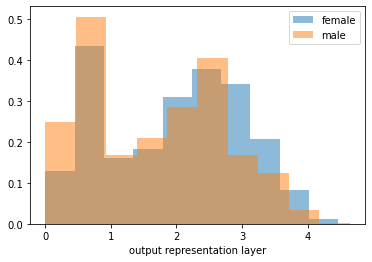

In [ ]:
# plot a histogram of the intermediate output distribution split based on the sensitive attribute
intermediate_layer_model = keras.models.Model(inputs = model2.input, outputs = model2.get_layer("dense_16").output)
intermediate_output_male = intermediate_layer_model.predict([rep_layer_male_test, male_test_sens])
intermediate_output_female = intermediate_layer_model.predict([rep_layer_female_test, female_test_sens])

plt.hist(intermediate_output_female, density = True, alpha=0.5, label='female')
plt.hist(intermediate_output_male, density = True, alpha=0.5, label='male')
plt.xlabel("output representation layer")
plt.legend(loc='best')
plt.savefig("hist_rep1.png")

In [ ]:
# get confusion matrix and fairness measures of fair model if sensitive attribute
# is readded for prediction of income
y_pred_female2 = model2.predict([rep_layer_female_test, female_test_sens])
y_pred_female2 = np.argmax(y_pred_female2, axis=1)

y_pred_male2 = model2.predict([rep_layer_male_test, male_test_sens])
y_pred_male2 = np.argmax(y_pred_male2, axis=1)

y_test_female_binary2 = np.argmax(y_test_female, axis=1)
y_test_male_binary2 = np.argmax(y_test_male, axis=1)

from sklearn.metrics import confusion_matrix
tn_female2, fp_female2, fn_female2, tp_female2 = confusion_matrix(y_test_female_binary2, y_pred_female2).ravel()
tn_male2, fp_male2, fn_male2, tp_male2 = confusion_matrix(y_test_male_binary2, y_pred_male2).ravel()

## female
prob_true_beutel_female2 = (tp_female2 + fp_female2)/y_test_female.shape[0]
print("prob_1 female (beutel):", prob_true_beutel_female2)
acc_female2 = (tp_female2 + tn_female2)/y_test_female.shape[0]
print("acc female:", acc_female2)
tpr_female2 = tp_female2/(tp_female2 + fn_female2)
print("tpr female:",tpr_female2)
ppv_female2 = tp_female2/(tp_female2 + fp_female2)
print("ppv female:",ppv_female2)
tnr_female2 = tn_female2/(tn_female2 + fp_female2)
print("tnr female:",tnr_female2)

print("---------------------------------------------------")
## male
prob_true_beutel_male2 = (tp_male2 + fp_male2)/y_test_male.shape[0]
print("prob_1 male (beutel):", prob_true_beutel_male2)
acc_male2 = (tp_male2 + tn_male2)/y_test_male.shape[0]
print("acc male:", acc_male2)
tpr_male2 = tp_male2/(tp_male2 + fn_male2)
print("tpr male:", tpr_male2)
ppv_male2 = tp_male2/(tp_male2 + fp_male2)
print("ppv male:",ppv_male2)
tnr_male2 = tn_male2/(tn_male2 + fp_male2)
print("tnr male:",tnr_male2)
print("---------------------------------------------------")

parity_gap_beutel2 = abs(prob_true_beutel_female2 - prob_true_beutel_male2)
pred_parity2 = abs(ppv_female2 - ppv_male2)
equal_opportunity2 = abs(tpr_female2 - tpr_male2) ## = equality_gap_1
equality_gap_0_beutel2 = abs(tnr_female2 - tnr_male2)
accuracy_gap2 = abs(acc_female2 - acc_male2)

print("parity gap (beutel):", parity_gap_beutel2)
print("predictive parity:", pred_parity2)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity2)
print("equality gap 0 (beutel):", equality_gap_0_beutel2)
print("accuracy gap:", accuracy_gap2)



prob_1 female (beutel): 0.7884154215089467
acc female: 0.8304740822726434
tpr female: 0.8472365969778514
ppv female: 0.9576509124941507
tnr female: 0.6932203389830508
---------------------------------------------------
prob_1 male (beutel): 0.9386740331491713
acc male: 0.7508287292817679
tpr male: 0.9923724355602315
ppv male: 0.7402393564842064
tnr male: 0.18673218673218672
---------------------------------------------------
parity gap (beutel): 0.15025861164022458
predictive parity: 0.21741155600994433
equal opportunity (equality gap 1 (beutel)): 0.1451358385823801
equality gap 0 (beutel): 0.5064881522508641
accuracy gap: 0.0796453529908755
